# In this project I implemnt my version of GBM using sklearn DecisionTreeRegressor from sklearn as base models.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [2]:
x = load_npz('x.npz')
y = np.load('y.npy')
y

array([ 1,  1, -1, ..., -1, -1,  1])

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape
y_train

array([ 1,  1, -1, ...,  1,  1,  1])

## 1. Gradient Boosting Implementation

The implementation of gradient boosting is in the file `boosting.py`.
### Function Instructions:

#### `__init__`

In `__init__`, a bunch of parameters are passed. Let's break down what each parameter represents:

- `base_model_class`: the class of the base model for our boosting
- `base_model_params`: a dictionary with hyperparameters for the base model
- `n_estimators`: the number of base models to be trained
- `learning_rate`: the learning rate, should be in the half-open interval $(0, 1]$
- `subsample`: the fraction of objects on which the base model will be trained (the proportion of the bootstrap sample from the original training set)
- `early_stopping_rounds`: the number of iterations after which, in the absence of improvement in the quality on the validation set, training stops

#### `fit`

In `fit`, two datasets are passed, training and validation. We train new base models on the training set and evaluate the quality for early stopping on the validation set (if the parameters allow).

First, we need to create some zero model, make predictions for the training and validation sets (in the template, this is a zero model, so the predictions are just `np.zeros`). After that, we need to train `n_estimators` base models (what and how base models are trained can be found in lectures and seminars). After each trained base model, we need to update the current predictions, calculate the error on the training and validation sets (use `loss_fn` for this), and check for early stopping.



#### `fit_new_base_model`

In `fit_new_base_model`, the entire training set (as is) and the current predictions for it are passed. We need to generate a bootstrap sample for training the base model and train the base model. After training the model, we run the search for the optimal gamma, add a new model and gamma (don't forget about the learning rate) to the respective lists.

#### `predict_proba`

In `predict_proba`, a dataset is passed, and we need to predict probabilities for it. Sum the predictions of base models on this dataset (don't forget about gammas) and apply the sigmoid function.

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
print('models are good')
assert len(boosting.gammas) == boosting.n_estimators
print('gammas are good')

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 627 ms, sys: 1.61 ms, total: 629 ms
Wall time: 632 ms
models are good
gammas are good
Train ROC-AUC 0.9892
Valid ROC-AUC 0.9125
Test ROC-AUC 0.9173


## 2. Training GBM

I will evaluate the performance on the test set of my boosting implementation using different maximum depths of the decision tree as the base model. Here and further, I will use the ROC-AUC metric.

I will iterate over the maximum depth from 1 to 30 with a step of 2 (leave other boosting parameters at their default values). Plot the dependence of the training and test set performance on the depth.

Best depth: 11


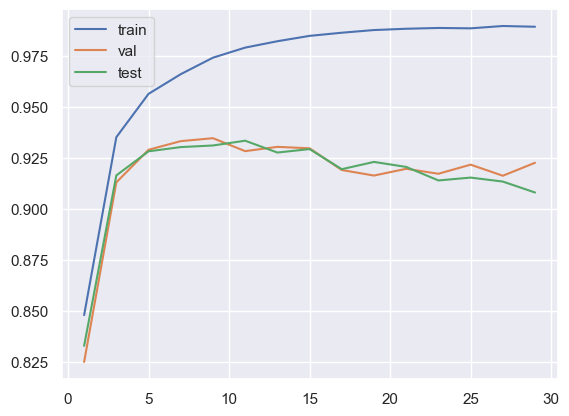

In [6]:
results = {}

depths = range(1, 30, 2)
aucs_train = []
aucs_test = []
aucs_val = []
for depth in depths:
    boosting = Boosting(base_model_params={'max_depth': depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    aucs_test.append(boosting.score(x_test, y_test))
    aucs_train.append(boosting.score(x_train, y_train))
    aucs_val.append(boosting.score(x_valid, y_valid))

print('Best depth:', depths[aucs_test.index(max(aucs_test))])

plt.plot(depths, aucs_train, label='train')
plt.plot(depths, aucs_val, label='val')
plt.plot(depths, aucs_test, label='test')
plt.legend()
plt.show()



The best model is boosting with trees of approximately 7-10 depth. With a lower depth, boosting underfits, and with a higher depth, it starts overfitting, as seen in the graph. The performance on the training set increases with the depth of the trees, while the performance on the validation and test sets begins to decrease. This indicates that with a depth greater than ~10, the model starts overfitting the training set and loses quality on the test and validation sets.

P.S. I write *approximately* because I did not fix the random states everywhere, and due to this, the results vary slightly from run to run.

## 3. Tuning Hyperparameters and Finding the Best Model 

I am tuning the hyperparameters based on the validation set to enhance the performance of my boosting model. It is essential to optimize the key parameters for both the gradient boosting algorithm and the underlying base models. For this task, I will utilize a hyperparameter optimization library, such as Optuna.

In [7]:
from optuna import create_study

# https://optuna.org/#code_examples

def boost(trial):
    max_depth = trial.suggest_int('max_depth', 1, 11, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100, step=5)
    n_estimators = trial.suggest_int('n_estimators', 50, 750, step=50)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1, step=0.05)
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 200, 600, step=50)
    boosting = Boosting(base_model_params={'max_depth': max_depth, 
                                           'min_samples_leaf': min_samples_leaf,
                                           'min_samples_split': min_samples_split}, 
                        n_estimators=n_estimators, 
                        learning_rate=learning_rate,
                        subsample=subsample, 
                        early_stopping_rounds=early_stopping_rounds)
    boosting.fit(x_train, y_train, x_valid, y_valid)
    score = boosting.score(x_valid, y_valid)
    return -score


study = create_study()
study.optimize(boost, n_trials=100)

study.best_params

[I 2023-12-24 19:28:28,189] A new study created in memory with name: no-name-8136cfcf-2061-4660-ab9a-68bb64f46b33
[I 2023-12-24 19:28:28,255] Trial 0 finished with value: -0.9196173791718449 and parameters: {'max_depth': 6, 'min_samples_leaf': 67, 'min_samples_split': 82, 'n_estimators': 700, 'learning_rate': 0.00857059337475254, 'subsample': 0.2, 'early_stopping_rounds': 500}. Best is trial 0 with value: -0.9196173791718449.
[I 2023-12-24 19:28:30,159] Trial 1 finished with value: -0.9356670043014511 and parameters: {'max_depth': 8, 'min_samples_leaf': 52, 'min_samples_split': 62, 'n_estimators': 500, 'learning_rate': 0.6870782645504345, 'subsample': 0.8, 'early_stopping_rounds': 350}. Best is trial 1 with value: -0.9356670043014511.
[I 2023-12-24 19:28:30,201] Trial 2 finished with value: -0.8971574822821557 and parameters: {'max_depth': 3, 'min_samples_leaf': 22, 'min_samples_split': 87, 'n_estimators': 350, 'learning_rate': 0.01102578112381576, 'subsample': 0.1, 'early_stopping_rou

{'max_depth': 10,
 'min_samples_leaf': 7,
 'min_samples_split': 32,
 'n_estimators': 100,
 'learning_rate': 0.3861410732432537,
 'subsample': 0.6,
 'early_stopping_rounds': 400}

In [8]:
params = study.best_params

In [9]:
# test with best parametrs

boosting = Boosting(base_model_params={'max_depth': params['max_depth'], 
                                       'min_samples_leaf': params['min_samples_leaf'],
                                       'min_samples_split': params['min_samples_split']},
                    n_estimators=params['n_estimators'],
                    learning_rate=params['learning_rate'],
                    subsample=params['subsample'],
                    early_stopping_rounds=params['early_stopping_rounds'])

boosting.fit(x_train, y_train, x_valid, y_valid)
print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Train ROC-AUC 0.9763
Valid ROC-AUC 0.9378
Test ROC-AUC 0.9359


## 4. Interpretation of GBM

Lets look at the GBM's calibration curve and compare it ot logisitic regression

In [10]:
def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        ind = np.where((preds >=l) & (preds < r))[0]
        mean = np.mean(preds[ind])
        real_ratio = np.sum(y_test[ind] == 1) / len(ind)
        
        bin_middle_points.append(mean)
        bin_real_ratios.append(real_ratio)
    plt.grid()

    plt.plot(bin_middle_points, bin_real_ratios, label=label)
    

In [11]:
from sklearn.metrics import roc_auc_score

y_pred = boosting.predict_proba(x_test)[:, 1]
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')


print(roc_auc_score(y_test == 1, y_pred))
np.min(y_pred), np.max(y_pred)

Test ROC-AUC 0.9359
0.9358706896144526


(0.00010661857757997414, 0.9954106582375224)

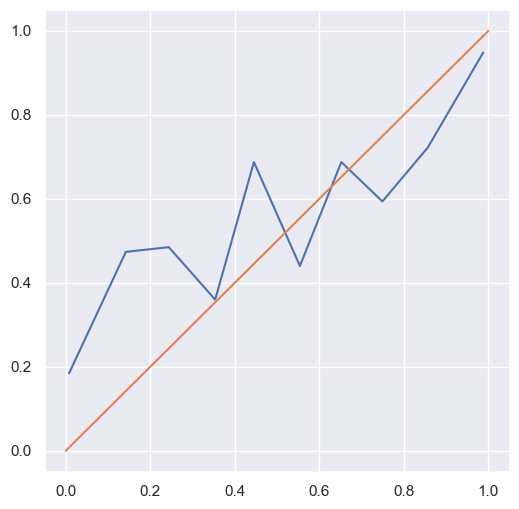

In [13]:
plt.figure(figsize=(6, 6))
plt.grid()
plot_calibration_curve(y_test, y_pred, "Boosting")
plt.plot([0, 1], [0, 1])
plt.tight_layout
plt.show()

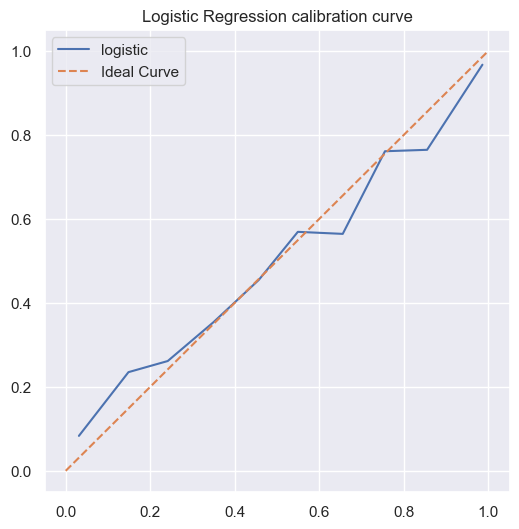

In [14]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict_proba(x_test)[:, 1]
plt.figure(figsize=(6, 6))

plot_calibration_curve(y_test, y_pred, 'logistic')

plt.title('Logistic Regression calibration curve');
plt.plot([0, 1], [0, 1], '--', label='Ideal Curve')
plt.legend()
plt.grid()
plt.show()

It is evident that logistic regression predicts probabilities significantly better. However, we don't expect this from boosting, as it was not trained specifically to predict probabilities well.

Now, let's try to assess the feature importance for boosting.

Since our base model is a tree from sklearn, we can compute the feature importance separately for each tree and then average them (use feature_importances_ from DecisionTreeRegressor). After that, normalize the values to sum up to one.

I add a feature_importances_ function that returns the described feature importances to my boosting implementation.

Plot a bar chart of feature importances. On the adjacent plot, draw the feature importance for logistic regression, using the absolute values of the weights.

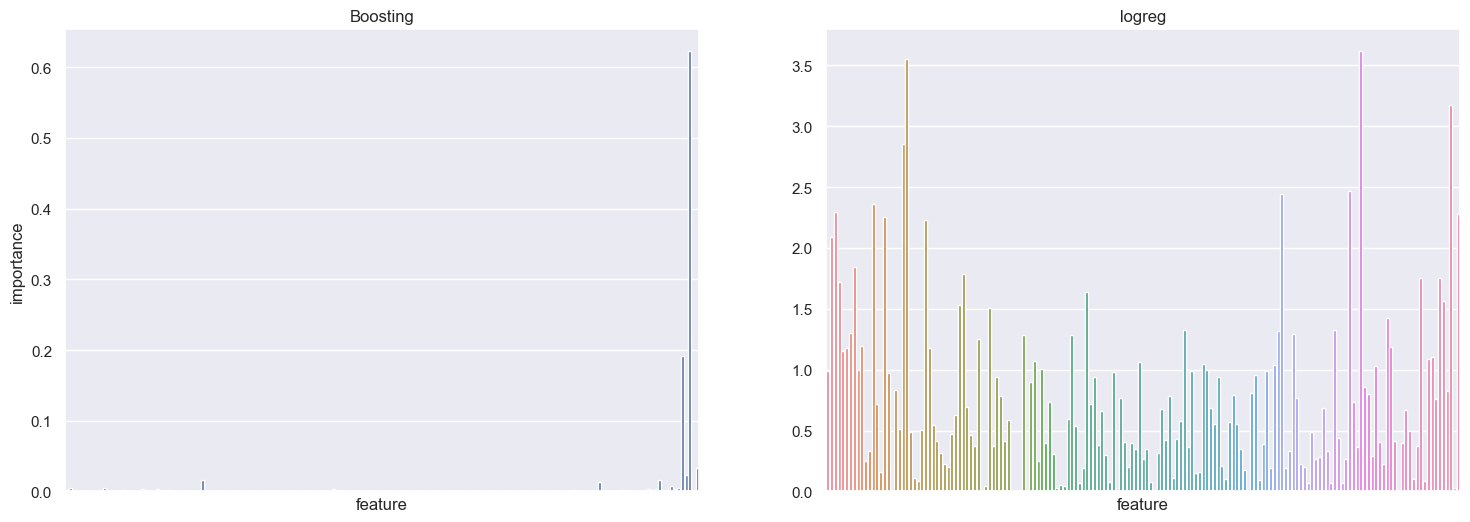

In [15]:

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Boosting')
sns.barplot(boosting.feature_importances_)
plt.xlabel('feature')
plt.ylabel('importance')
plt.xticks([])
plt.subplot(1,2,2)
plt.title('logreg')
sns.barplot(np.abs(lr.coef_))
plt.xticks([])
plt.xlabel('feature')
plt.show()

For boosting, approximately 4 features are important, making it easier to select crucial features. In contrast, logistic regression exhibits a more evenly distributed importance among features. In logistic regression, a large number of features are considered significant.

Let's try to filter features based on their importance.

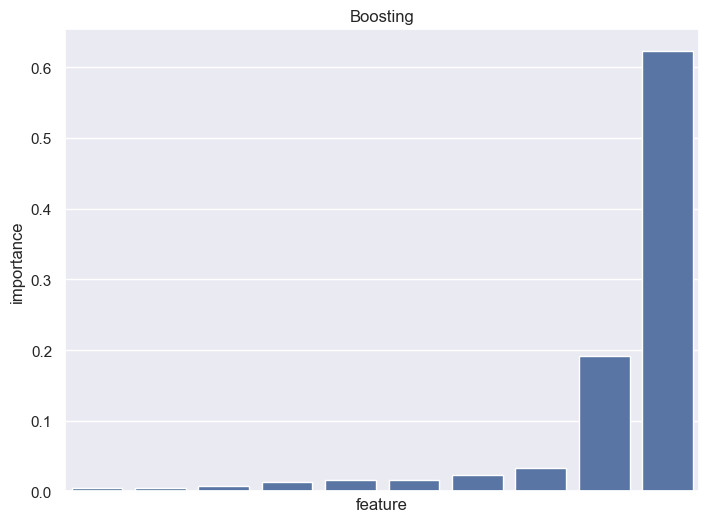

In [16]:

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Boosting')
sns.barplot(np.sort(boosting.feature_importances_)[-10:])
plt.xlabel('feature')
plt.ylabel('importance')
plt.xticks([])
plt.show()

Let's keep only the top 10 most important features.

In [17]:
idx = np.argsort(boosting.feature_importances_)[-10:]


x_short = x[:, idx]

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_short, y, test_size=0.2, random_state=1337)

x_test_s, x_valid_s, y_test_s, y_valid_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=1337)


In [18]:
boosting_s = Boosting(base_model_params={'max_depth': params['max_depth'], 
                                       'min_samples_leaf': params['min_samples_leaf'],
                                       'min_samples_split': params['min_samples_split']},
                    n_estimators=params['n_estimators'],
                    learning_rate=params['learning_rate'],
                    subsample=params['subsample'],
                    early_stopping_rounds=params['early_stopping_rounds'])
boosting_s.fit(x_train_s, y_train_s, x_valid_s, y_valid_s)
print(f'Train ROC-AUC {boosting_s.score(x_train_s, y_train_s):.4f}')
print(f'Valid ROC-AUC {boosting_s.score(x_valid_s, y_valid_s):.4f}')
print(f'Test ROC-AUC {boosting_s.score(x_test_s, y_test_s):.4f}')


Train ROC-AUC 0.9734
Valid ROC-AUC 0.9361
Test ROC-AUC 0.9339


We managed to reduce the number of features almost 17 times with almost no loss of quality. This simplifies computations, which is good.

## 5. Blending

Implement blending with your best model and logistic regression and see whether the quality will improve

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score


lr = LogisticRegression()

lr.fit(x_train, y_train)

train = np.array([boosting.predict_proba(x_train)[:, 1], lr.predict_proba(x_train)[:, 1]]).T
valid = np.array([boosting.predict_proba(x_valid)[:, 1], lr.predict_proba(x_valid)[:, 1]]).T
test = np.array([boosting.predict_proba(x_test)[:, 1], lr.predict_proba(x_test)[:, 1]]).T

blend = LinearRegression()
blend.fit(train, y_train)

trainpred = blend.predict(train)
validpred = blend.predict(valid)
testpred = blend.predict(test)

print(f'Train ROC-AUC {roc_auc_score(y_train == 1, trainpred)}')
print(f'Valid ROC-AUC {roc_auc_score(y_valid == 1, validpred)}')
print(f'Test ROC-AUC {roc_auc_score(y_test == 1, testpred)}')

Train ROC-AUC 0.9747706991261453
Valid ROC-AUC 0.944217226078815
Test ROC-AUC 0.9398797555749043


So we can see that the quality has improved a bit

## 6. Finally let's compare our model with Catboost implementation of GBM



In [20]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


model = CatBoostClassifier()
X_train = np.concatenate((x_train.toarray(), x_valid.toarray()))
Y_train = np.concatenate((y_train, y_valid))

model.fit(x_train, y_train)
model.score(x_test, y_test)
print(f'Train ROC-AUC {roc_auc_score(y_train == 1, model.predict_proba(x_train)[:, 1])}')
print(f'Valid ROC-AUC {roc_auc_score(y_valid == 1, model.predict_proba(x_valid)[:, 1])}')
print(f'Test ROC-AUC {roc_auc_score(y_test == 1, model.predict_proba(x_test)[:, 1])}')

Learning rate set to 0.036078
0:	learn: 0.6491456	total: 60.4ms	remaining: 1m
1:	learn: 0.6106099	total: 63.2ms	remaining: 31.6s
2:	learn: 0.5804628	total: 65.5ms	remaining: 21.8s
3:	learn: 0.5522560	total: 67.7ms	remaining: 16.9s
4:	learn: 0.5262191	total: 70ms	remaining: 13.9s
5:	learn: 0.5008078	total: 72.2ms	remaining: 12s
6:	learn: 0.4812964	total: 74.6ms	remaining: 10.6s
7:	learn: 0.4620363	total: 77.6ms	remaining: 9.63s
8:	learn: 0.4461815	total: 80.5ms	remaining: 8.86s
9:	learn: 0.4303349	total: 82.7ms	remaining: 8.18s
10:	learn: 0.4142074	total: 84.9ms	remaining: 7.63s
11:	learn: 0.4011999	total: 87.2ms	remaining: 7.18s
12:	learn: 0.3907486	total: 89.4ms	remaining: 6.79s
13:	learn: 0.3808039	total: 91.7ms	remaining: 6.46s
14:	learn: 0.3710193	total: 93.8ms	remaining: 6.16s
15:	learn: 0.3641416	total: 96.1ms	remaining: 5.91s
16:	learn: 0.3554514	total: 98.4ms	remaining: 5.69s
17:	learn: 0.3492318	total: 101ms	remaining: 5.49s
18:	learn: 0.3419544	total: 103ms	remaining: 5.32s
1

Even without tuning hyperparameters for CatBoost, the quality turned out to be even better than blending, and it trained faster!